Deep Learning
=============

## Assignment 3 - Regularization
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### L2 regularization on a logistic model

In [25]:
'''
Setting up of the TensorFlow graph
The beta constant value is set to a small value and multiplied with the L2 norm of the weight to penalize large values.
'''
batch_size = 128
graph = tf.Graph()

with graph.as_default():
    # Input data
    # For training data we use a placeholder that will be fed at runtime
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape = (batch_size, image_size * image_size)) # 128, 28*28
    tf_train_labels = tf.placeholder(tf.float32,
                                     shape = (batch_size, num_labels)) # 128, 10
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_constant = tf.placeholder(tf.float32)
    
    # Variables - weights and bias
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels])) # 28*28, 10
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training 
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
                beta_constant * tf.nn.l2_loss(weights) # using the 0.002 value for the beta constant
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
    
    
        
'''
Running TensorFlow Logistic Model
'''   
num_steps = 3001

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in xrange(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, 
                     tf_train_labels : batch_labels,
                     beta_constant : 0.002} # hard coding beta value
        
        _, l, predictions = session.run([optimizer, 
                                         loss, 
                                         train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):           
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 28.001463
Minibatch accuracy: 6.2%
Validation accuracy: 9.3%
Minibatch loss at step 500: 2.525669
Minibatch accuracy: 81.2%
Validation accuracy: 77.2%
Minibatch loss at step 1000: 1.376055
Minibatch accuracy: 78.9%
Validation accuracy: 79.8%
Minibatch loss at step 1500: 0.705039
Minibatch accuracy: 84.4%
Validation accuracy: 81.0%
Minibatch loss at step 2000: 0.659546
Minibatch accuracy: 86.7%
Validation accuracy: 81.4%
Minibatch loss at step 2500: 0.658754
Minibatch accuracy: 81.2%
Validation accuracy: 81.2%
Minibatch loss at step 3000: 0.790505
Minibatch accuracy: 82.0%
Validation accuracy: 82.0%
Test accuracy: 89.2%


### Finding the right value for the beta parameter 

In [26]:
'''
Run the TF model on a range of Beta values
'''
num_steps = 3001
# Beta values to iterate over
beta_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []
print("Iterating over the following beta values: \n\n",regul_val)

for beta in beta_val:
    with tf.Session(graph = graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, 
                         tf_train_labels : batch_labels, 
                         beta_constant : beta}
            
            _, l, predictions = session.run([optimizer, 
                                             loss, 
                                             train_prediction], feed_dict=feed_dict)
        
        # Append all the accuracy scores for the corresponding beta values.
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Iterating over the following beta values: 

 [0.0001, 0.00012589254117941674, 0.00015848931924611142, 0.00019952623149688809, 0.00025118864315095823, 0.00031622776601683826, 0.00039810717055349773, 0.00050118723362727296, 0.00063095734448019429, 0.00079432823472428294, 0.001000000000000002, 0.0012589254117941701, 0.0015848931924611173, 0.001995262314968885, 0.0025118864315095872, 0.0031622776601683889, 0.0039810717055349856, 0.0050118723362727402, 0.0063095734448019554, 0.0079432823472428467]


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


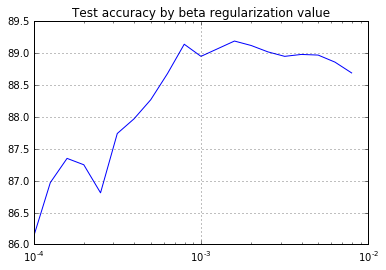

In [28]:
'''
Plotting the test accuracy by beta value
'''
import matplotlib.pyplot as plt
%pylab inline

plt.semilogx(beta_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by beta regularization value')
plt.show()

## L2 regularization using a 1 layer neural network 

In [44]:
'''
Set up TF graph
'''

batch_size = 128
num_hidden_nodes = 1024
graph = tf.Graph()


with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, 
                                     shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_constant = tf.placeholder(tf.float32)
    
    # First hidden layer
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    hidden_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    
    # Final layer
    weights = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    logits = tf.matmul(hidden_1, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) \
                + beta_constant * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    
    layer1_validation = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
    validation_prediction = tf.nn.softmax(tf.matmul(layer1_validation, weights) + biases)
    
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
    test_prediction = tf.nn.softmax(tf.matmul(layer1_test, weights) + biases)

In [45]:
'''
Run TF graph
'''
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, 
                     tf_train_labels : batch_labels, 
                     beta_constant : 1e-4}
            
        _, l, predictions = session.run([optimizer, 
                                         loss, 
                                         train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(validation_prediction.eval(), valid_labels))

    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 386.652130
Minibatch accuracy: 6.2%
Validation accuracy: 30.2%
Minibatch loss at step 500: 54.191212
Minibatch accuracy: 80.5%
Validation accuracy: 78.8%
Minibatch loss at step 1000: 35.871338
Minibatch accuracy: 78.1%
Validation accuracy: 79.8%
Minibatch loss at step 1500: 29.173382
Minibatch accuracy: 90.6%
Validation accuracy: 81.4%
Minibatch loss at step 2000: 28.224617
Minibatch accuracy: 88.3%
Validation accuracy: 81.4%
Minibatch loss at step 2500: 24.483812
Minibatch accuracy: 86.7%
Validation accuracy: 81.8%
Minibatch loss at step 3000: 24.411398
Minibatch accuracy: 78.9%
Validation accuracy: 82.5%
Test accuracy: 89.7%


### Finding the right value for the beta parameter

In [53]:
# num_steps = 3001
num_steps = 30
# beta_values = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
beta_values = [0.003, 0.002, 0.001]
accuracy_val = []

for beta in beta_values:    
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, 
                         tf_train_labels : batch_labels, 
                         beta_constant : beta}
            _, l, predictions = session.run([optimizer, 
                                             loss, 
                                             train_prediction], feed_dict=feed_dict)
        # Get accuracy scores
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))
        print("Step in.")

Step in.
Step in.
Step in.


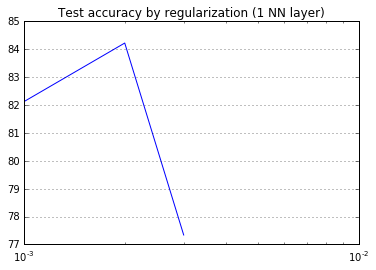

In [54]:
'''
Plot accuracy scores for beta values
'''
plt.semilogx(beta_values, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (1 NN layer)')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [5]:
'''
Set up TF graph
'''
batch_size = 128
num_hidden_nodes = 1024
graph = tf.Graph()


with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, 
                                     shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_constant = tf.placeholder(tf.float32)
    
    # First hidden layer
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    hidden_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    
    # Final layer
    weights = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    logits = tf.matmul(hidden_1, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) \
                + beta_constant * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    
    layer1_validation = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
    validation_prediction = tf.nn.softmax(tf.matmul(layer1_validation, weights) + biases)
    
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
    test_prediction = tf.nn.softmax(tf.matmul(layer1_test, weights) + biases)

In [9]:
'''
Run TF graph using a restrictive constraint of just 3 batches
'''
num_steps = 300
num_batches = 2

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        
        
        offset = step % num_batches
        
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, 
                     tf_train_labels : batch_labels, 
                     beta_constant : 1e-4}
            
        _, l, predictions = session.run([optimizer, 
                                         loss, 
                                         train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(validation_prediction.eval(), valid_labels))

    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 402.550934
Minibatch accuracy: 8.6%
Validation accuracy: 30.4%
Minibatch loss at step 100: 31.101215
Minibatch accuracy: 100.0%
Validation accuracy: 62.3%
Minibatch loss at step 200: 30.791746
Minibatch accuracy: 100.0%
Validation accuracy: 62.3%
Test accuracy: 68.2%


** Minibatch accuracy: 100.0% ** 

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [23]:
'''
Set up 1 layer NN with dropout during training
'''

batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset= tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables
    # Hidden layer
    # truncated_normal(shape) where shape is the shape of the output tensor
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    # tf.zeros([3, 4], tf.int32) ==> [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
    biases_1 = tf.Variable(tf.zeros([num_hidden_nodes])) 
    # Output layer
    weights = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))    
    # Training
    layer_1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    #############################################
    dropout = tf.nn.dropout(layer_1_train, 0.5)
    #############################################
    logits = tf.matmul(dropout, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    
    layer_1_validation_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
    validation_prediction = tf.nn.softmax(tf.matmul(layer_1_validation_prediction, weights) + biases)
    
    layer_1_testing_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
    testing_prediction = tf.nn.softmax(tf.matmul(layer_1_testing_prediction, weights) + biases)


In [26]:
'''
Run NN Graph
'''
num_steps = 900
# num_batches = 5

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized.")
    for step in xrange(num_steps):
        # Overfitting offset
#         offset = step % num_batches
        # Non overfitting offset
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate mini batch
        batch_data = train_dataset[offset : (offset + batch_size), :]
        batch_labels = train_labels[offset: (offset + batch_size), :]
        # Dictionary to feed to mini batch
        feed_dict = {tf_train_dataset : batch_data,
                     tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, 
                                         loss, 
                                         train_prediction], feed_dict = feed_dict)
        if (step % 100 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(validation_prediction.eval(), valid_labels))

    print("Test accuracy: %.1f%%" % accuracy(testing_prediction.eval(), test_labels))
    

Initialized.
Minibatch loss at step 0: 497.118408
Minibatch accuracy: 6.2%
Validation accuracy: 23.2%
Minibatch loss at step 100: 46.612938
Minibatch accuracy: 71.9%
Validation accuracy: 80.2%
Minibatch loss at step 200: 166.212311
Minibatch accuracy: 64.1%
Validation accuracy: 75.7%
Minibatch loss at step 300: 25.870216
Minibatch accuracy: 72.7%
Validation accuracy: 79.8%
Minibatch loss at step 400: 42.795425
Minibatch accuracy: 68.0%
Validation accuracy: 79.8%
Minibatch loss at step 500: 33.458065
Minibatch accuracy: 77.3%
Validation accuracy: 79.8%
Minibatch loss at step 600: 16.348604
Minibatch accuracy: 82.0%
Validation accuracy: 79.1%
Minibatch loss at step 700: 37.543747
Minibatch accuracy: 71.9%
Validation accuracy: 80.5%
Minibatch loss at step 800: 18.191017
Minibatch accuracy: 75.0%
Validation accuracy: 79.0%
Test accuracy: 87.1%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [36]:
'''
Set up 3 layer NN 
'''

batch_size = 128
num_hidden_nodes = 1024
num_hidden_nodes_2 = 256
num_hidden_nodes_3 = 128

graph = tf.Graph()
with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset= tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
    
    # Variables
    # Hidden layer 1
    # truncated_normal(shape) where shape is the shape of the output tensor
    '''
    truncated_normal()
    The generated values follow a normal distribution with specified mean and standard deviation, 
    except that values whose magnitude is more than 2 standard deviations from the mean are dropped and re-picked.
    '''
    
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_hidden_nodes_2], 
                                                stddev=np.sqrt(2.0 / num_hidden_nodes)))
    biases_2 = tf.Variable(tf.zeros([num_hidden_nodes_2]))
    
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_nodes_2, num_hidden_nodes_3], 
                                               stddev=np.sqrt(2.0 / num_hidden_nodes_2)))
    biases_3 = tf.Variable(tf.zeros([num_hidden_nodes_3]))
    
        
    # Output layer
    weights = tf.Variable(tf.truncated_normal([num_hidden_nodes_3, num_labels], 
                                             stddev=np.sqrt(2.0 / num_hidden_nodes_3)))
    biases = tf.Variable(tf.zeros([num_labels]))    
    
    
    # Training
    layer_1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    layer_2_train = tf.nn.relu(tf.matmul(layer_1_train, weights_2) + biases_2)
    layer_3_train = tf.nn.relu(tf.matmul(layer_2_train, weights_3) + biases_3)
    

    logits = tf.matmul(layer_3_train, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer
    '''
    tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate, staircase=False, name=None)
    learning_rate: A scalar float32 or float64 Tensor or a Python number. The initial learning rate.
    global_step: A scalar int32 or int64 Tensor or a Python number. Global step to use for the decay computation. 
                 Must not be negative.
    decay_steps: A scalar int32 or int64 Tensor or a Python number. Must be positive. See the decay computation above.
    decay_rate: A scalar float32 or float64 Tensor or a Python number. The decay rate.
    staircase: Boolean. If True decay the learning rate at discrete intervals
    '''
    learning_rate = tf.train.exponential_decay(0.5,
                                               global_step,
                                               3000,
                                               0.70,
                                               staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, 
                                                                          global_step = global_step)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    
    layer_1_validation_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
    layer_2_validation_prediction = tf.nn.relu(tf.matmul(layer_1_validation_prediction, weights_2) + biases_2)
    layer_3_validation_prediction = tf.nn.relu(tf.matmul(layer_2_validation_prediction, weights_3) + biases_3)
    validation_prediction = tf.nn.softmax(tf.matmul(layer_3_validation_prediction, weights) + biases)
    
    layer_1_testing_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
    layer_2_testing_prediction = tf.nn.relu(tf.matmul(layer_1_testing_prediction, weights_2) + biases_2)
    layer_3_testing_prediction = tf.nn.relu(tf.matmul(layer_2_testing_prediction, weights_3) + biases_3)
    testing_prediction = tf.nn.softmax(tf.matmul(layer_3_testing_prediction, weights) + biases)

In [37]:
'''
Run NN Graph
'''
num_steps = 5000
# num_batches = 5

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized.")
    for step in xrange(num_steps):
        # Overfitting offset
#         offset = step % num_batches
        # Non overfitting offset
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate mini batch
        batch_data = train_dataset[offset : (offset + batch_size), :]
        batch_labels = train_labels[offset: (offset + batch_size), :]
        # Dictionary to feed to mini batch
        feed_dict = {tf_train_dataset : batch_data,
                     tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, 
                                         loss, 
                                         train_prediction], feed_dict = feed_dict)
        if (step % 1000 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(validation_prediction.eval(), valid_labels))

    print("Test accuracy: %.1f%%" % accuracy(testing_prediction.eval(), test_labels))
    

Initialized.
Minibatch loss at step 0: 10.227684
Minibatch accuracy: 7.8%
Validation accuracy: 10.0%
Minibatch loss at step 1000: nan
Minibatch accuracy: 8.6%
Validation accuracy: 10.0%
Minibatch loss at step 2000: nan
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 3000: nan
Minibatch accuracy: 7.8%
Validation accuracy: 10.0%
Minibatch loss at step 4000: nan
Minibatch accuracy: 10.9%
Validation accuracy: 10.0%
Test accuracy: 10.0%
